In [148]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os, sys

In [149]:
%matplotlib inline

# Read single NetCDF file
using the Xarray package: https://xarray.pydata.org/en/stable/

In [150]:
ds=xr.open_dataset('ssp585/t2m/tasIs_LImon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc')

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tasIs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [151]:
ds.tasIs.comment

'quantity averaged over ice_sheet (meaning grounded ice sheet and floating ice shelf) only, to avoid contamination from other surfaces (eg: permafrost)'

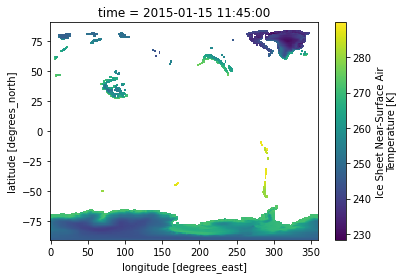

In [152]:
ds.tasIs[0].plot()

In [332]:
scenario = 'ssp585'
varname = 'tas'
postfix = 'Amon'
subdir = 't2m'

ds=xr.open_mfdataset(f'{scenario}/{subdir}/{varname}_{postfix}*.nc',combine='by_coords')

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [336]:
result = monthly_to_yearly(ds[varname])

In [337]:
#result.to_netcdf(f'output/{scenario}/annual/') # for example! has to be completed

# Antarctica mask

A simple AIS mask can be constructed off the land fraction mask that CESM provides. We just select everything south of 60S. 

In [157]:
ds2 = xr.open_dataset('cam_LANDFRAC.nc')

In [158]:
landfrac = ds2.LANDFRAC.squeeze()

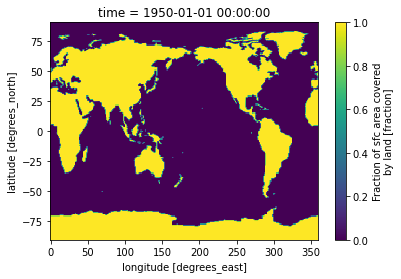

In [159]:
#landfrac[0:100,0:100].plot()
landfrac.plot()

In [160]:
lon = ds.lon
lat = ds.lat
lon2d, lat2d = np.meshgrid(lon,lat)

In [161]:
ais_mask = xr.where(lat2d<-60., landfrac, 0)
ais_mask.name = 'AIS_MASK'
ais_mask = ais_mask.reset_coords('time', drop=True) # drop time dimension

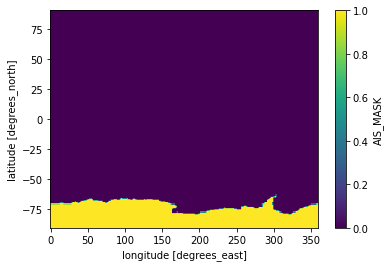

In [162]:
ais_mask.plot()

## Peninsula

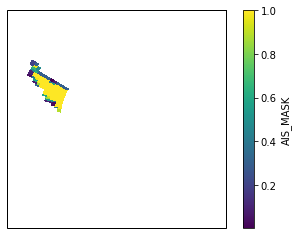

In [360]:

fig = plt.figure()
ax = fig.subplots(subplot_kw={'projection':ccrs.SouthPolarStereo()})

ax.set_extent((-180,180,-90,-60), crs=ccrs.PlateCarree())

#layout_ax(ax)
#ais_mask.plot.pcolormesh('lon2d','lat2d',ax=ax, transform=ccrs.PlateCarree())
pen_mask = xr.where((lon2d>275) * (lon2d<330), 1, np.NaN) * ais_mask * xr.where(lat2d>-74,1,np.NaN)

elev_sel = xr.where((ais_oro > 0.1) * (ais_oro < 100), 1, 0)
pen_shelves = wais_mask * elev_sel
pen_grounded = wais_mask * xr.where(ais_oro > 100., 1, 0)

#wais_shelves.plot(ax=ax,transform=ccrs.PlateCarree())
pen_mask.plot(ax=ax,transform=ccrs.PlateCarree())

## West Antarctica

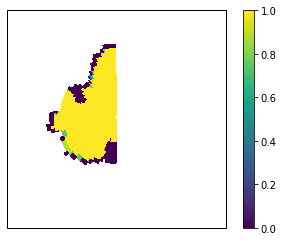

In [362]:

fig = plt.figure()
ax = fig.subplots(subplot_kw={'projection':ccrs.SouthPolarStereo()})

ax.set_extent((-180,180,-90,-60), crs=ccrs.PlateCarree())

#layout_ax(ax)
#ais_mask.plot.pcolormesh('lon2d','lat2d',ax=ax, transform=ccrs.PlateCarree())
wais_mask = (xr.where(lon2d>180, 1, np.NaN) * ais_mask)
wais_mask = xr.where(pen_mask>0, np.NaN, wais_mask)

elev_sel = xr.where((ais_oro > 0.1) * (ais_oro < 100), 1, 0)
wais_shelves = wais_mask * elev_sel
wais_grounded = wais_mask * xr.where(ais_oro > 100., 1, 0)

#wais_shelves.plot(ax=ax,transform=ccrs.PlateCarree())
wais_grounded.plot(ax=ax,transform=ccrs.PlateCarree())

## East Antarctica

In [363]:
# ToDo

# eais_mask = 
# eais_grounded = 
# eais_shelves = 

## Looping the different regions

In [308]:
{'apple':4, 'pear': 10}

{'apple': 4, 'pear': 10}

In [364]:
my_masks = {'ais': ais_mask,
            'wais': wais_mask, 
            'wais_shelves': wais_shelves,
            'wais_grounded': wais_grounded}

In [321]:
my_masks.keys()

dict_keys(['wais', 'wais_shelves', 'wais_grounded'])

In [327]:
def calculate_timeseries(mask, variable):
    total_area = (mask * area).sum().item()
    print('{:.0f}'.format(total_area/1e6),'km2')
    return (variable * mask.values * area.values).sum(dim=['lat','lon'])/total_area


INFO: working on mask: ais
14162571 km2
INFO: working on mask: wais
4502471 km2
INFO: working on mask: wais_shelves
459175 km2
INFO: working on mask: wais_grounded
4043264 km2


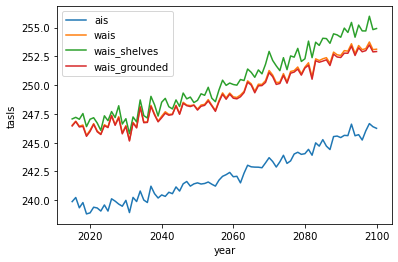

In [365]:

fig, ax = plt.subplots()

for key in my_masks.keys():
    print(f'INFO: working on mask: {key}')
    mask = my_masks[key]
    
    timeseries = calculate_timeseries(mask, t2m_ann)
    timeseries.plot(ax=ax, label=key)

ax.legend()

Calculate SMB

`SMB  = snow + rain - evap - runoff`

# Time series of mean annual temperature over AIS
To calculate a area-weighted mean temperature, we need to know what is the area of AIS. For this we read the `areacella` variable. 

In [275]:
ds_area = xr.open_dataset('fx/areacella_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc')
area = ds_area.areacella

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [276]:
total_area_AIS = (ais_mask * area).sum().item()
print(total_area_AIS, area.units)

14162570772480.0 m2


In [277]:
total_area_AIS/1e6 # in km2

14162570.77248

### Step 1: convert monthly to annual data

In [334]:
# days per month, assuming no leap years
dpm = np.array((31 ,28 ,31 ,30 ,31 ,30 ,31 ,31 ,30 ,31 ,30 ,31 )) 


def mul_with_dpm(data):
    """
    This helper function multiplies a monthly array (e.g. Xarray DataArray) with the number
    of days per month, and then divides by the total of days in the year. 
    """
    return (data * dpm[:,np.newaxis,np.newaxis]).sum(dim='time') / dpm.sum()

def monthly_to_yearly(data):
    """
    This function converts a 'timeseries' of monthly data to a timeseries of yearly data. 
    An approximation to this function is: 
    
        data.groupby('time.year').mean()
        
    But that doesn't take into account the different lengths of the months. 

    NOTE:
        This function assumes a 365-day calendar for each year (no leap, as is common in climate models).
    """
    out = data.groupby('time.year').apply(mul_with_dpm)
    out.attrs = data.attrs
    return out

monthly_to_yearlyrt monthly data into annual data using either:
* Method 1: simple grouping per year
* Method 2: weighing the number of days per month

These methods will give a comparable, but slightly different answer. Let's go with method 2 since it's more accurate. 

In [ ]:
# step 1: load the netcdf
# step 2: take the variable
# step 3:



In [114]:
#t2m_ann = ds.tas.groupby('time.year').mean() # Method 1
t2m_ann = monthly_to_yearly(ds.tasIs) # Method 2

In [115]:
t2m_ann.shape

(86, 192, 288)

### Step 2: calculate AIS average

In [290]:
t2m_ann_ais = (t2m_ann * ais_mask.values * area.values).sum(dim=['lat','lon'])/total_area_AIS

In [291]:
t2m_ann_ais.load();

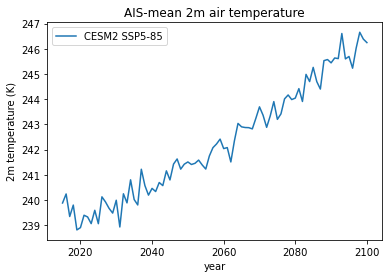

In [292]:
t2m_ann_ais.plot(label='CESM2 SSP5-85')
plt.title('AIS-mean 2m air temperature')
plt.ylabel('2m temperature (K)');
plt.legend()

In [119]:
t2m_ann_ais.to_netcdf('tmp.nc')

# Elevation

In [246]:
with xr.open_dataset('ssp585/fx/orog_fx_CESM2-WACCM_ssp585_r1i1p1f1_gn.nc') as ds:
    orog = ds.orog

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'orog' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [247]:
#orog.plot()

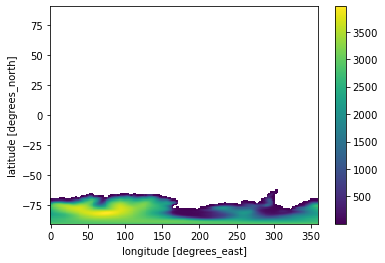

In [248]:
(orog*ais_mask).plot()

In [249]:
ais_oro = orog*ais_mask

A possible subselection of AIS grid points based on elevation (elev < 100 m)

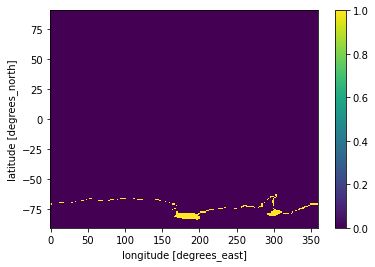

In [250]:
elev_sel = xr.where((ais_oro > 0.1) * (ais_oro < 100), 1, 0)
elev_sel.plot()

# Map projections

In [220]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [228]:
def add_2d_coordinate_information(var):
    lon2d, lat2d = np.meshgrid(var.lon,var.lat)
    var.coords['lon2d'] = xr.DataArray(lon2d, dims=('lat', 'lon'))
    var.coords['lat2d'] = xr.DataArray(lat2d, dims=('lat', 'lon'))   
    
    
def change_value_to_missing(var, value=0.0):
    return xr.where(var==value, np.NaN, var)

In [230]:
add_2d_coordinate_information(ais_mask)

# Set zero values to Not-A-Number, which removes them from the plot altogether. 
ais_mask = change_value_to_missing(ais_mask, value=0.0)

In [238]:
def layout_ax(ax):    
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN) ## BUG in cartopy 0.16: draws ocean everywhere on NorthPolarStereo projection
    ax.add_feature(cfeature.LAND)
    #ax.add_feature(cfeature.COASTLINE)

Plot the AIS mask with a South Polar projection

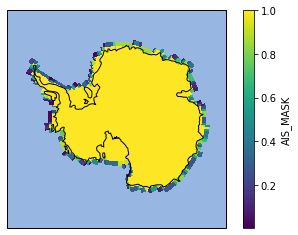

In [239]:
fig = plt.figure()
ax = fig.subplots(subplot_kw={'projection':ccrs.SouthPolarStereo()})

ax.set_extent((-180,180,-90,-60), crs=ccrs.PlateCarree())

layout_ax(ax)
ais_mask.plot.pcolormesh('lon2d','lat2d',ax=ax, transform=ccrs.PlateCarree())

In [233]:
with xr.open_dataset('AIS_Grounded_basins_Zwally_CESMgrid.nc') as ds:
    basins = ds.Zwallybasins

In [234]:
add_2d_coordinate_information(basins)
basins = change_value_to_missing(basins, value=0.0)

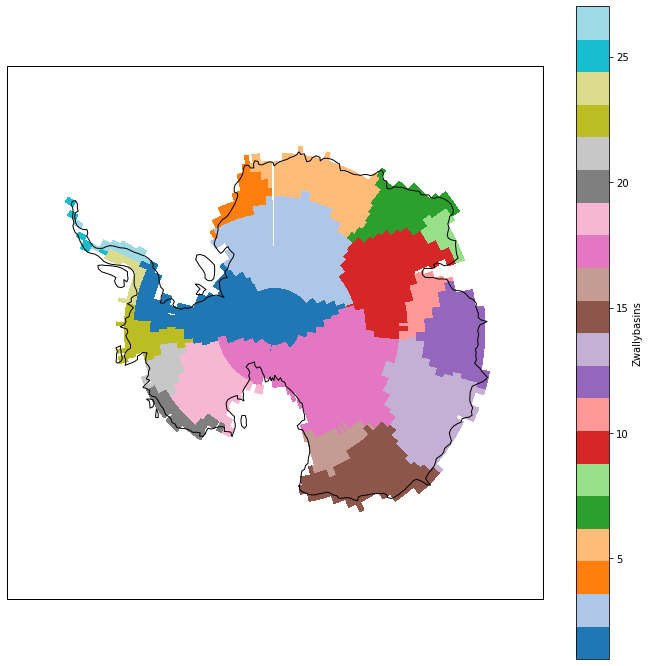

In [242]:
fig = plt.figure(figsize=(12,12))
ax = fig.subplots(subplot_kw={'projection':ccrs.SouthPolarStereo()})

ax.set_extent((-180,180,-90,-60), crs=ccrs.PlateCarree())

ax.coastlines()
basins.plot.pcolormesh('lon2d','lat2d',ax=ax, transform=ccrs.PlateCarree(), cmap='tab20')


In [256]:
def make_SouthPolar_plot_of_var(var, extent=(-180,180,-90,-60), figsize=(8,8)):
    """
    Convenience function to make a Polar Projection plot with few lines of code
    """
    add_2d_coordinate_information(var)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.subplots(subplot_kw={'projection':ccrs.SouthPolarStereo()})
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    ax.coastlines()  
    
    var.plot.pcolormesh('lon2d','lat2d',ax=ax, transform=ccrs.PlateCarree())

    return fig,ax

Now plot the selection we made earlier, based on the elevation < 100 m threshold.

(<Figure size 576x576 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7ff9484631d0>)

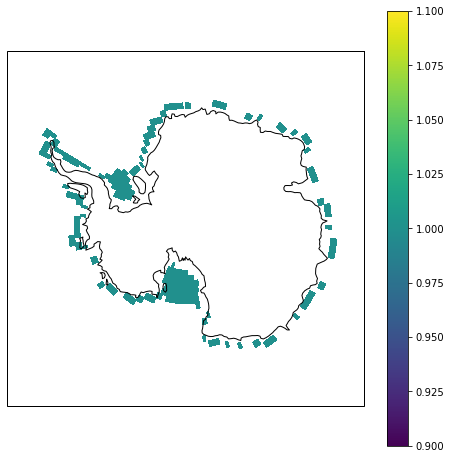

In [259]:
elev_sel = change_value_to_missing(elev_sel, value=0.0)
make_SouthPolar_plot_of_var(elev_sel)

# Snowfall

In [260]:
with xr.open_dataset('ssp585/precip/prsnIs_LImon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc') as ds:
    snow = ds.prsnIs

/Users/leo/anaconda3/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'prsnIs' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [262]:
sec_in_year = 365*24*3600

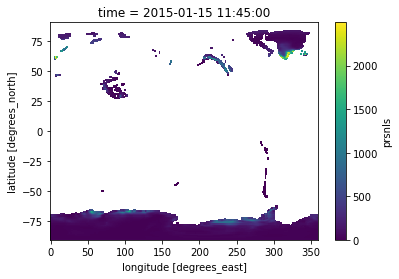

In [263]:
(snow[0]*sec_in_year).plot()

In [264]:
snow_ann = monthly_to_yearly(snow)

In [288]:
(snow_ann*ais_mask.values*area.values).sum(dim=['lat','lon']) * sec_in_year * 1e-12

<xarray.DataArray 'prsnIs' (year: 86)>
array([3277.18846314, 3406.46563543, 3278.86726604, 3409.3885128 ,
       3155.36758355, 3211.21117734, 3324.03333193, 3463.0286792 ,
       3359.07838671, 3347.61808095, 3175.17931943, 3394.38955477,
       3365.60030082, 3215.74502782, 3490.46210249, 3298.64488619,
       3135.4935848 , 3588.84284395, 3376.5821087 , 3489.844428  ,
       3322.97941018, 3503.2969545 , 3508.71985001, 3373.64411334,
       3350.89199054, 3488.04836212, 3490.50471115, 3550.60011657,
       3472.55588063, 3652.64733528, 3472.80520388, 3475.79967724,
       3686.99583479, 3565.54636903, 3453.50014324, 3459.32014045,
       3744.5319946 , 3724.64334603, 3234.63041646, 3669.85520447,
       3497.62169469, 3532.8972185 , 3697.05396181, 3674.88347306,
       3779.61646342, 3730.53919503, 3769.75800428, 3755.90015904,
       3815.50271062, 3850.10053082, 3731.24850976, 3536.74062147,
       3941.11190264, 3752.77789342, 3929.50593279, 3853.68952351,
       3803.15453054, 4050.18307725, 3971.12044196, 3999.3821022 ,
       4100.1854177 , 3911.18104945, 4199.94932721, 4030.30254308,
       4135.01498503, 4253.20865766, 3865.05092913, 3967.50959925,
       4314.6628368 , 4097.29900901, 4337.03280039, 4336.97271728,
       4357.88668186, 4241.59594763, 4262.1067263 , 4406.32141079,
       4489.51005757, 4249.16819576, 4404.55808599, 4353.15077124,
       4239.00947735, 4374.43397975, 4530.65128774, 4391.82859246,
       4615.94616216, 4635.1574367 ])
Coordinates:
  * year     (year) int64 2015 2016 2017 2018 2019 ... 2096 2097 2098 2099 2100